### 作业5.2：利用Pytorch的`torch.nn.Module`来重新实现小测验 (12.16之前提交)

* 网络层自己用torch.nn.Module实现
* 优化器和loss使用现成的即可

In [1]:
from sklearn import datasets
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch

In [3]:
print(f"torch.cuda.is_available() = {torch.cuda.is_available()}")
print(f"torch.cuda.device_count() = {torch.cuda.device_count()}")
if 'CUDA_VISIBLE_DEVICES' in os.environ:
    print(f"os.environ['CUDA_VISIBLE_DEVICES'] = {os.environ['CUDA_VISIBLE_DEVICES']}")
else:
    print(f"没有设置环境变量 'CUDA_VISIBLE_DEVICES'")

torch.cuda.is_available() = True
torch.cuda.device_count() = 1
os.environ['CUDA_VISIBLE_DEVICES'] = 2


In [4]:
def load_boston(ratio=0.8):
    X, Y = datasets.load_boston(True)
    Y.shape = -1, 1
    
#     # normalization
#     X = X/80
#     Y = Y/(np.max(Y) - np.min(Y))
    num_samples = len(Y)
    num_train = math.ceil(num_samples * ratio)
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = X[idx[:num_train]], Y[idx[:num_train]]
    validdata = X[idx[num_train:]], Y[idx[num_train:]]
    
    return traindata, validdata

# MLP Quiz

关于boston数据集：$n_{in}=13, n_{out}=1$，为了降低计算量，设定$n_{mid} = 30$

In [5]:
class MyModel(torch.nn.Module):
    def __init__(self, in_features,mid_features, out_features):
        super().__init__()
        
        self.fc1 = torch.nn.Linear(in_features, mid_features)
        self.activation = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(mid_features, out_features)
        
    def forward(self, X):
        return self.fc2(self.activation(self.fc1(X)))
    
    def fit(self,X_train,Y_train,opt,iternum=2000,Verbose=True):
        self.valid_losses = []
        self.train_losses = []
        loss = torch.nn.MSELoss()
        
        for i in range(iternum):
            opt.zero_grad()
            X, Y = X_train, Y_train
            l = loss(self.forward(X), Y)
            l.backward()
            opt.step()
            
            with torch.no_grad():
                cur_train_loss = l
                cur_valid_loss = loss(Y_valid, self.forward(X_valid))
                self.valid_losses.append(cur_valid_loss) 
                self.train_losses.append(cur_train_loss)
                if Verbose:
                    if i%(iternum/20) == 0:
                        print(f"Iter {i}: loss {cur_train_loss:.4f}, valid loss {cur_valid_loss:.4f}")
        if Verbose:
            plt.plot(self.train_losses)
            plt.plot(self.valid_losses)
            plt.legend(["train loss", "validation loss"])

In [6]:
print("preparing data")
(X_train, Y_train), (X_valid, Y_valid) = load_boston()
X_train, Y_train = torch.Tensor(X_train).cuda(), torch.Tensor(Y_train).cuda()
X_valid, Y_valid = torch.Tensor(X_valid).cuda(), torch.Tensor(Y_valid).cuda()

preparing data


Iter 0: loss 583.1694, valid loss 581.8045
Iter 100: loss 446.5988, valid loss 447.3784
Iter 200: loss 400.4091, valid loss 400.3124
Iter 300: loss 367.7767, valid loss 367.0029
Iter 400: loss 341.8563, valid loss 340.4943
Iter 500: loss 320.1898, valid loss 318.3023
Iter 600: loss 301.5272, valid loss 299.1612
Iter 700: loss 285.1297, valid loss 282.3221
Iter 800: loss 270.5176, valid loss 267.2983
Iter 900: loss 257.3588, valid loss 253.7527
Iter 1000: loss 245.4118, valid loss 241.4399
Iter 1100: loss 234.4947, valid loss 230.1751
Iter 1200: loss 224.4662, valid loss 219.8152
Iter 1300: loss 215.2145, valid loss 210.2459
Iter 1400: loss 206.6486, valid loss 201.3751
Iter 1500: loss 198.6936, valid loss 193.1267
Iter 1600: loss 191.2872, valid loss 185.4371
Iter 1700: loss 184.3767, valid loss 178.2528
Iter 1800: loss 177.9169, valid loss 171.5278
Iter 1900: loss 171.8688, valid loss 165.2225
CPU times: user 3.05 s, sys: 176 ms, total: 3.23 s
Wall time: 3.27 s


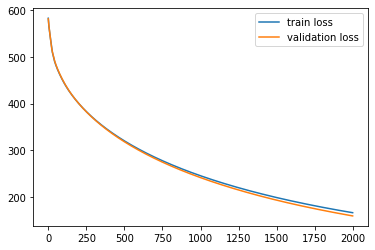

In [7]:
%%time

lr=0.006239076671107937
model= MyModel(X_train.shape[1],30,1)
model=model.cuda()
opt = torch.optim.Adagrad(model.parameters(),lr=lr)
model.fit(X_train,Y_train,opt,iternum=2000,Verbose=True)

In [12]:
# list1=np.linspace(-10,-2,40)
# list1=np.exp(list1)
# now1=float("inf")
# now2=float("inf")
# for index,lr in enumerate(list1):
#     print(index)
#     model= MyModel(X_train.shape[1],30,1)
#     model=model.cuda()
#     opt = torch.optim.SGD(model.parameters(),lr=lr)
#     model.fit(X_train,Y_train,opt,iternum=4000,Verbose=False)
    
#     currentmin1=min(model.train_losses)
#     currentmin2=min(model.valid_losses)
    
#     if currentmin1<now1:
#         now1=currentmin1
#         ans1=(currentmin1,lr)
#         print("ans1",ans1)
#     if currentmin2<now2:
#         now2=currentmin2
#         ans2=(currentmin2,lr)
#         print("ans2",ans2)
# print(ans1,ans2)
### adagrad，lr= 0.006239076671107937,  train_loss= 90.2585,valid_loss=60.6900
### adam，lr= 0.00023428450238202782,  train_loss= 90.2585,valid_loss=60.6900

In [13]:
# dir(torch.optim)